## Tasselled cap indices compared between geomedian composite and summary

make sure you have run the bash script (by running source jload_stats.sh) on the command line before you open this notebook,
otherwise it won't work.


#### The following sensors are available for the following time frames:
- Landsat 5 - 1986 to April 1999 followed by a gap until May 2003 - November 2011 (data from 2009 onwards becomes less reliable in southern Australia)
- Landsat 7 - April 1999 to present, however after May 2003 the scan line corrector (SLC) failed, so data are referred to as SLC-off, meaning they've got a venetian blinds appearance with wedges of missing data. This data is not well suited for inclusion in composites, but is fine to use in time series analysis
- Landsat 8 - April 2013 onwards


Notebook created by Bex Dunn using code from Erin Telfer, February 2018

This notebook creates a geomedian composite for a polygon area

In [21]:
### here we are checking that we have the modules loaded into your terminal session.
!module list

print(
'''your output above should look like this:
Currently Loaded Modulefiles:
  1) /agdc-py3-env/20171214   4) /agdc_statistics/0.9a7
  2) /agdc-py3/1.5.4          5) udunits/2.1.24
  3) /agdc-py3-prod/1.5.4     6) /dea-prod/20171219''')

Currently Loaded Modulefiles:
  1) /agdc-py3-env/20171214   4) /agdc_statistics/0.9a7
  2) /agdc-py3/1.5.4          5) udunits/2.1.24
  3) /agdc-py3-prod/1.5.4     6) /dea-prod/20171219
your output above should look like this:
Currently Loaded Modulefiles:
  1) /agdc-py3-env/20171214   4) /agdc_statistics/0.9a7
  2) /agdc-py3/1.5.4          5) udunits/2.1.24
  3) /agdc-py3-prod/1.5.4     6) /dea-prod/20171219


### import some modules

In [10]:
#note to bex - clean up these modules if you don't use them all

In [3]:
import pandas as pd
import xarray as xr
from datetime import date, timedelta
import gdal
from gdal import *

import datacube
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from datacube_stats.statistics import GeoMedian

from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import matplotlib.dates
from IPython.display import display
import ipywidgets as widgets

dc = datacube.Datacube(app='dc-tcw and geomedian')


In [4]:
#libraries for polygon and polygon mask
import fiona
import shapely.geometry
import rasterio.features
import rasterio
from datacube.utils import geometry

In [182]:
#for drawing rgb composite plots
from skimage import exposure
import numpy as np
from matplotlib.pyplot import imshow

#for writing to netcdf
from datacube.storage.storage import write_dataset_to_netcdf

#for making plot axes and colorbars work
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Define a function to deal with polygon inputs:

In [5]:
def open_polygon_from_shapefile(shapefile, index_of_polygon_within_shapefile=0):
    '''hide the messy process of getting a polygon input, opening it using fiona and getting the geopolygon out of it for the datacube query 
    within this function. It will also make sure you have the correct crs object for the DEA'''

    # open all the shapes within the shape file
    shapes = fiona.open(shapefile)
    i =index_of_polygon_within_shapefile
    print('shapefile index is '+str(i))
    if i > len(shapes):
        print('index not in the range for the shapefile'+str(i)+' not in '+str(len(shapes)))
        sys.exit(0)
    #copy attributes from shapefile and define shape_name
    geom_crs = geometry.CRS(shapes.crs_wkt)
    geo = shapes[i]['geometry']
    geom = geometry.Geometry(geo, crs=geom_crs)
    geom_bs = shapely.geometry.shape(shapes[i]['geometry'])
    shape_name = shapefile.split('/')[-1].split('.')[0]+'_'+str(i)
    print('the name of your shape is '+shape_name)
    #get your polygon out as a geom to go into the query, and the shape name for file names later
    return geom, shape_name

### Define a function to load nbart and pixel quality

In [6]:
def load_nbart(sensor,query, bands_of_interest): 
    '''loads nbart data for a sensor, masks using pq, then filters out terrain -999s
    function written 23-08-2017 based on dc v1.5.1'''  
    dataset = []
    product_name = '{}_{}_albers'.format(sensor, 'nbart')
    print('loading {}'.format(product_name))
    ds = dc.load(product=product_name, measurements=bands_of_interest,
                 group_by='solar_day', **query)
    #grab crs defs from loaded ds if ds exists
    if ds:
        crs = ds.crs
        affine = ds.affine
        print('loaded {}'.format(product_name))
        mask_product = '{}_{}_albers'.format(sensor, 'pq')
        sensor_pq = dc.load(product=mask_product, fuse_func=ga_pq_fuser,
                            group_by='solar_day', **query)
        if sensor_pq:
            print('making mask {}'.format(mask_product))
            cloud_free = masking.make_mask(sensor_pq.pixelquality,
                                           cloud_acca='no_cloud',
                                           cloud_shadow_acca = 'no_cloud_shadow',                           
                                           cloud_shadow_fmask = 'no_cloud_shadow',
                                           cloud_fmask='no_cloud',
                                           blue_saturated = False,
                                           green_saturated = False,
                                           red_saturated = False,
                                           nir_saturated = False,
                                           swir1_saturated = False,
                                           swir2_saturated = False,
                                           contiguous=True)
            ds = ds.where(cloud_free)
            ds.attrs['crs'] = crs
            ds.attrs['affine'] = affine
            print('masked {} with {} and filtered terrain'.format(product_name,mask_product))
            # nbarT is correctly used to correct terrain by replacing -999.0 with nan
            ds=ds.where(ds!=-999.0)
        else: 
            print('did not mask {} with {}'.format(product_name,mask_product))
    else:
        print ('did not load {}'.format(product_name)) 

    if len(ds)>0:
        return ds
    else:
        return None

### define a function to draw true color plots

In [27]:
def drawTrueColour(ds, time = 0):
    '''code by Mike Barnes Feb 2018 draws true color plots. 
    altered by bex for drawing composites with no time dimension'''
    #t, y, x = ds['red'].shape
    y, x = ds['red'].shape
    rawimg = np.zeros((y,x,3), dtype = np.float32)
    for i, colour in enumerate(['red','green','blue']):
        #rawimg[:,:,i] = ds[colour][time].values
        rawimg[:,:,i] = ds[colour].values
    rawimg[rawimg == -999] = np.nan
    img_toshow = exposure.equalize_hist(rawimg, mask = np.isfinite(rawimg))
    fig = plt.figure(figsize=[10,10])
    imshow(img_toshow)
    ax = plt.gca()
    #ax.set_title(str(ds.time[time].values))


### define a function to write to netcdf based on the datacube 'write_dataset_to_netcdf' function

In [95]:
def write_your_netcdf(data, dataset_name, filename,crs):
    '''this function turns an xarray dataarray into a dataset so we can write it to netcdf. It adds on a crs definition
    from the original array. data = your xarray dataset, dataset_name is a string describing your variable'''    
    #turn array into dataset so we can write the netcdf
    if isinstance(data,xr.DataArray):
        dataset= data.to_dataset(name=dataset_name)
    elif isinstance(data,xr.Dataset):
        dataset = data
    else:
        print('your data might be the wrong type, it is: '+type(data))
    #grab our crs attributes to write a spatially-referenced netcdf
    dataset.attrs['crs'] = crs
    #dataset.dataset_name.attrs['crs'] = crs
    try:
        write_dataset_to_netcdf(dataset, filename)
    except RuntimeError as err:
        print("RuntimeError: {0}".format(err))        

### Define the function to calculate tasselled cap wetness without a time dimension

In [139]:
#calculating tasselled cap wetness
def calc_wetness_gm(gm_data):
    '''This function performs the tasselled cap transformation, multiplying band data by tasselled cap coefficients to 
    produce a "wetness" "band".
    gm_data is geomedian of surface reflectance data loaded from the datacube
    we're just using the landsat 5 coefficients at the moment as the differences are small, until Dale's are published.
    Coefficients are from Crist and Cicone 1985 "A TM Tasseled Cap equivalent transformation for reflectance factor data"
    function written 23-08-2017 based on dc v1.5.1. updated 13-02-2018 bd'''
    if gm_data:
        wetness_coeff = {'blue':0.0315, 'green':0.2021, 'red':0.3102, 'nir':0.1594, 'swir1':-0.6806, 'swir2':-0.6109}
        # make a deep copy of the data
        wbg = gm_data.copy(deep=True)
        #iterate over the spectral bands
        for band_name in gm_data.data_vars:
            #multiply each band by the transform coefficient to get a band-specific value
            wetness_band = gm_data[band_name]*wetness_coeff[band_name]
            #update the existing band data with the TC data
            #by making new bands, called wet_green, bright_green etc.
            wbg.update({'wet_'+band_name:(['y','x'],wetness_band)})
            #then drop the original bands
            wbg = wbg.drop({band_name})    
        #sum the values for each band to get the tcw dim    
        wbg['wetness']=wbg.wet_blue+wbg.wet_green+wbg.wet_red+wbg.wet_nir+wbg.wet_swir1+wbg.wet_swir2
        bands_to_drop =[]
        for new_band in wbg.data_vars:
            bands_to_drop.append(new_band)            
        bands_to_drop.remove('wetness')    
        wbg = wbg.drop(bands_to_drop)
        print('calculated wetness for gm')
        return wbg    
    else:
        print('did not calculate wetness for gm')
        return None            

In [174]:
#calculating tasselled cap wetness
def calc_wetness(sensor_data,sensor):
    '''This function performs the tasselled cap transformation, multiplying band data by tasselled cap coefficients to 
    produce a "wetness" "band".
    sensor_data is surface reflectance data loaded from the datacube
    sensor = 'ls5, 'ls7' or 'ls8'
    Coefficients are from Crist and Cicone 1985 "A TM Tasseled Cap equivalent transformation for reflectance factor data"
    function written 23-08-2017 based on dc v1.5.1. updated 19-10-2017 bd'''

    wetness_coeff = {'ls5':{'blue':0.0315, 'green':0.2021, 'red':0.3102, 'nir':0.1594, 'swir1':-0.6806, 'swir2':-0.6109},
                    'ls7':{'blue':0.0315, 'green':0.2021, 'red':0.3102, 'nir':0.1594, 'swir1':-0.6806, 'swir2':-0.6109},
                    'ls8':{'blue':0.0315, 'green':0.2021, 'red':0.3102, 'nir':0.1594, 'swir1':-0.6806, 'swir2':-0.6109}}
    #if there is sensor data for the time period
    if sensor_data is not None: 
         # make a deep copy of the sensor data
        wbg = sensor_data.copy(deep=True)
        #iterate over the spectral bands
        for band_name in sensor_data.data_vars:
            #multiply each band by the transform coefficient to get a band-specific value
            wetness_band = sensor_data[band_name]*wetness_coeff[sensor][band_name]
            #update the existing band data with the TC data
            #by making new bands, called wet_green, bright_green etc.
            wbg.update({'wet_'+band_name:(['time','y','x'],wetness_band)})
            #then drop the original bands
            wbg = wbg.drop({band_name})    
        #sum the values for each band to get the tcw dim    
        wbg['wetness']=wbg.wet_blue+wbg.wet_green+wbg.wet_red+wbg.wet_nir+wbg.wet_swir1+wbg.wet_swir2
        bands_to_drop =[]
        for new_band in wbg.data_vars:
            bands_to_drop.append(new_band)            
        bands_to_drop.remove('wetness')    
        wbg = wbg.drop(bands_to_drop)
        print('calculated wetness for {}'.format(sensor))
        return wbg    
    else:
        print('did not calculate wetness for {}'.format(sensor))
        return None            

### Define a function to calculate wetness over a threshold

In [169]:
def calc_wetness_overthresh(wetness,threshold=-400):
    '''Calculate the wetness values where wetness>threshold. Inputs are wetness array and threshold value, 
    default threshold is -400. Band for wetness>threshold is added to wetness. This is not the count.'''
    if wetness is not None:
#         with warnings.catch_warnings():
#             #suppress irritating behaviour in xarray.where
#             warnings.simplefilter("ignore")
            wetness['wetness_over_threshold'] = wetness.wetness.where(wetness.wetness>threshold)
            print('thresholded wetness added to array')
            return wetness
    else:
        print('did not calculate wetness over threshold' )
        return None    

### define function to count a TC index (bright/wet/green) (for one sensor)

In [179]:
def count_tcindex_1sensor(over_threshold, tcindex, tci_over_threshold):
    '''count the number of tci-flagged scenes for each pixel,
    count the amount of times that tci value is above the set threshold
    load both into memory (this assumes you are using dask),
    return a dictionary of total count and threshold count
    ###FIXME currently only runs over 1 sensor!!!'''
    if over_threshold is not None:
        #count the number of flagged scenes for each pixel
        total_count = over_threshold[tcindex].count(dim='time')

        #count the amount of times that water plus wet veg is above the threshold
        threshold_count= over_threshold[tci_over_threshold].count(dim='time')
       
        #define dictionary of total count and threshold count
        counts = {'total count':total_count, 'threshold count':threshold_count}
        
        count_of_ex = counts['threshold count']/counts['total count']
        print('counted')
        return count_of_ex, counts
    else:
        print('did not count')
        return None      

In [ ]:
wetness_count_of_ex_sensor3,wcounts_sensor_3_nbart = count_tcindex_1sensor(wet_overthresh, 'wetness','wetness_over_threshold')

In [132]:
nbart_gm

<xarray.Dataset>
Dimensions:  (x: 1216, y: 783)
Coordinates:
  * y        (y) float64 -1.325e+06 -1.325e+06 -1.325e+06 -1.325e+06 ...
  * x        (x) float64 3.133e+05 3.134e+05 3.134e+05 3.134e+05 3.134e+05 ...
Data variables:
    blue     (y, x) float64 534.6 532.6 524.2 514.3 515.7 519.8 523.7 523.9 ...
    green    (y, x) float64 747.5 743.6 721.4 709.6 715.7 719.6 727.1 726.2 ...
    red      (y, x) float64 915.8 905.6 868.9 843.8 852.1 863.0 876.8 877.8 ...
    nir      (y, x) float64 2.181e+03 2.167e+03 2.131e+03 2.128e+03 ...
    swir1    (y, x) float64 2.859e+03 2.821e+03 2.702e+03 2.665e+03 ...
    swir2    (y, x) float64 1.805e+03 1.773e+03 1.677e+03 1.631e+03 ...
Attributes:
    crs:      EPSG:3577
    affine:   | 25.00, 0.00, 313325.00|\n| 0.00,-25.00,-1324850.00|\n| 0.00, ...

### specify input and output directories

In [7]:
###input folder is where your data is coming from, so you don't have to type it all the time:
#input_folder = '/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_shapefiles/'
input_folder = '/g/data/r78/rjd547/groundwater_activities/Whole_NA/WholeNA_shapes/small_shapes/'

###Where you want your data to go when it's saved
output_folder = '/g/data/r78/rjd547/groundwater_activities/Arafura_sw/'

### Define input area

#### get geometry and name your shape by getting a polygon from a shapefile

In [9]:
geom, shape_name = open_polygon_from_shapefile(input_folder+'arafura_sml.shp')

shapefile index is 0
the name of your shape is arafura_sml_0


#### Uncomment for lat/long specs instead of polygon:

In [10]:
# #Specify lat and long max and minimum corners
# lat_min = -20.375 #down
# lat_max = -20.340 #up
# lon_min = 148.757 #left
# lon_max = 148.806 #right

### Set up the datacube query by specifying polygon area, spectral bands, epoch of interest and which landsat sensors you require

In [11]:
#pick a time range
start_of_epoch = '2014-01-01'
end_of_epoch =  '2017-12-31'

#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = ['blue',
                     'green',
                     'red',
                     'nir',
                     'swir1',
                     'swir2'
                     ]

query = {
    'time': (start_of_epoch, end_of_epoch), 'geopolygon': geom,
}

In [12]:
#this is done separately instead of in a loop because the datasets can be quite large.
#currently this is a way of memory handling -there is probably a better way of doing it.
#sensor1_nbart=load_nbart('ls5',query, bands_of_interest)
#sensor2_nbart=load_nbart('ls7',query,bands_of_interest)
sensor3_nbart=load_nbart('ls8',query,bands_of_interest)

loading ls8_nbart_albers


/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: casting an xarray.Dataset to a boolean will change in xarray v0.11 to only include data variables, not coordinates. Cast the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  # Remove the CWD from sys.path while we load stuff.


loaded ls8_nbart_albers


/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: casting an xarray.Dataset to a boolean will change in xarray v0.11 to only include data variables, not coordinates. Cast the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.


making mask ls8_pq_albers
masked ls8_nbart_albers with ls8_pq_albers and filtered terrain


/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/ipykernel_launcher.py:42: FutureWarning: calling len() on an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Call len() on the Dataset.variables property instead, like ``len(ds.variables)``, to preserve existing behavior in a forwards compatible manner.


 ### broken bit

In [14]:
nbart=sensor3_nbart.sortby('time')

### Run the geomedian

In [15]:
#geomedian transform
nbart_gm=GeoMedian().compute(nbart)

In [23]:
#check that the geomedian is in there
print(nbart_gm)

<xarray.Dataset>
Dimensions:  (x: 1216, y: 783)
Coordinates:
  * y        (y) float64 -1.325e+06 -1.325e+06 -1.325e+06 -1.325e+06 ...
  * x        (x) float64 3.133e+05 3.134e+05 3.134e+05 3.134e+05 3.134e+05 ...
Data variables:
    blue     (y, x) float64 534.6 532.6 524.2 514.3 515.7 519.8 523.7 523.9 ...
    green    (y, x) float64 747.5 743.6 721.4 709.6 715.7 719.6 727.1 726.2 ...
    red      (y, x) float64 915.8 905.6 868.9 843.8 852.1 863.0 876.8 877.8 ...
    nir      (y, x) float64 2.181e+03 2.167e+03 2.131e+03 2.128e+03 ...
    swir1    (y, x) float64 2.859e+03 2.821e+03 2.702e+03 2.665e+03 ...
    swir2    (y, x) float64 1.805e+03 1.773e+03 1.677e+03 1.631e+03 ...
Attributes:
    crs:      EPSG:3577
    affine:   | 25.00, 0.00, 313325.00|\n| 0.00,-25.00,-1324850.00|\n| 0.00, ...


### draw a true color plot just to prove we can

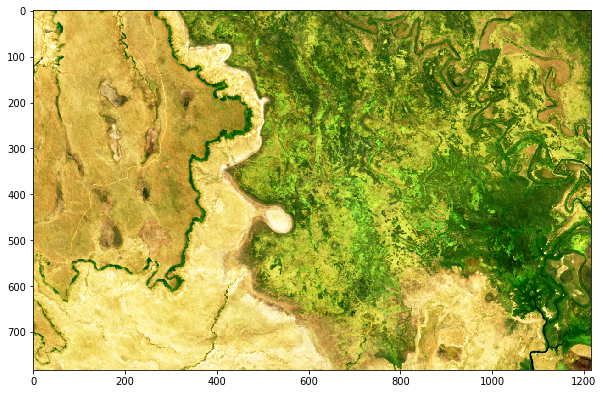

In [32]:
drawTrueColour(nbart_gm)

### Calculate the tasselled cap wetness transform on the geomedian composite

In [140]:
wetness_nbart_gm=calc_wetness_gm(nbart_gm)

calculated wetness for gm


/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: casting an xarray.Dataset to a boolean will change in xarray v0.11 to only include data variables, not coordinates. Cast the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  if __name__ == '__main__':


In [143]:
wetness_nbart_gm

<xarray.Dataset>
Dimensions:  (x: 1216, y: 783)
Coordinates:
  * y        (y) float64 -1.325e+06 -1.325e+06 -1.325e+06 -1.325e+06 ...
  * x        (x) float64 3.133e+05 3.134e+05 3.134e+05 3.134e+05 3.134e+05 ...
Data variables:
    wetness  (y, x) float64 -2.249e+03 -2.209e+03 -2.092e+03 -2.049e+03 ...
Attributes:
    crs:      EPSG:3577
    affine:   | 25.00, 0.00, 313325.00|\n| 0.00,-25.00,-1324850.00|\n| 0.00, ...

### Plot the wetness for this composite

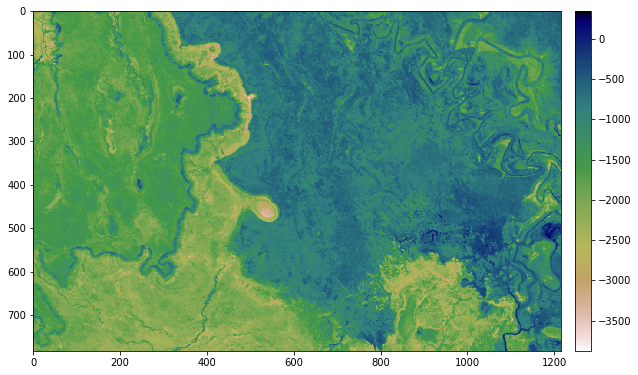

In [164]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.clf()
plt.figure(figsize=(10,10))
ax = plt.gca()
im = ax.imshow(wetness_nbart_gm.wetness, cmap='gist_earth_r')
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
plt.colorbar(im, cax=cax)
plt.show()

### calculate the overthreshold wetness

In [189]:
calc_wetness_overthresh(wetness_nbart_gm)

thresholded wetness added to array


<xarray.Dataset>
Dimensions:                 (x: 1216, y: 783)
Coordinates:
  * y                       (y) float64 -1.325e+06 -1.325e+06 -1.325e+06 ...
  * x                       (x) float64 3.133e+05 3.134e+05 3.134e+05 ...
Data variables:
    wetness                 (y, x) float64 -2.249e+03 -2.209e+03 -2.092e+03 ...
    wetness_over_threshold  (y, x) float64 nan nan nan nan nan nan nan nan ...
Attributes:
    crs:      EPSG:3577
    affine:   | 25.00, 0.00, 313325.00|\n| 0.00,-25.00,-1324850.00|\n| 0.00, ...

### plot overthreshold wetness for this composite

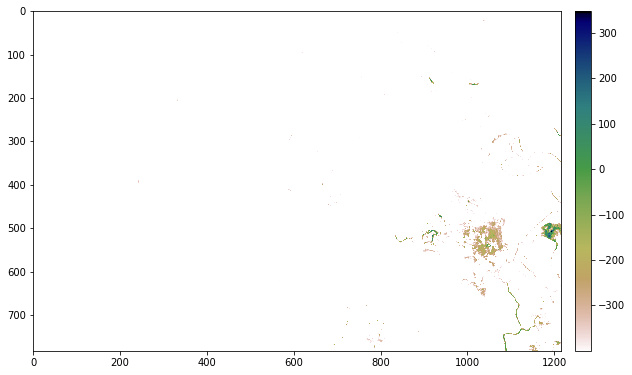

In [190]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.clf()
plt.figure(figsize=(10,10))
ax = plt.gca()
im = ax.imshow(wetness_nbart_gm.wetness_over_threshold, cmap='gist_earth_r')
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
plt.colorbar(im, cax=cax)
plt.show()

## Now make a wetness summary for comparison

In [176]:
wetness_nbart = calc_wetness(nbart, sensor='ls8')

calculated wetness for ls8


In [177]:
calc_wetness_overthresh(wetness_nbart)

thresholded wetness added to array


<xarray.Dataset>
Dimensions:                 (time: 87, x: 1216, y: 783)
Coordinates:
  * time                    (time) datetime64[ns] 2014-01-11T01:05:53.500000 ...
  * y                       (y) float64 -1.325e+06 -1.325e+06 -1.325e+06 ...
  * x                       (x) float64 3.133e+05 3.134e+05 3.134e+05 ...
Data variables:
    wetness                 (time, y, x) float64 nan nan nan nan nan nan nan ...
    wetness_over_threshold  (time, y, x) float64 nan nan nan nan nan nan nan ...
Attributes:
    crs:      EPSG:3577
    affine:   | 25.00, 0.00, 313325.00|\n| 0.00,-25.00,-1324850.00|\n| 0.00, ...

In [180]:
wetness_count_of_ex_nbart,wcounts_nbart = count_tcindex_1sensor(wetness_nbart, 'wetness','wetness_over_threshold')

counted


### plot wetness summary for the nbart timeseries

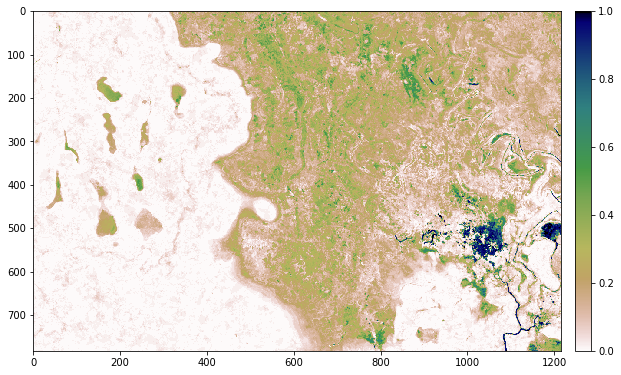

In [184]:
plt.clf()
plt.figure(figsize=(10,10))
ax = plt.gca()
im = ax.imshow(wetness_count_of_ex_nbart, cmap='gist_earth_r')
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
plt.colorbar(im, cax=cax)
plt.show()

## Run the geomedian on the overthreshold wetness, to see what happens:

In [ ]:
#geomedian transform
nbart_gm=GeoMedian().compute(wetness_nbart.wetness)

In [48]:
# #check if the file has already been written:
filename = output_folder+shape_name+'_'+start_of_epoch+'_'+end_of_epoch+'_ls8_gmcomposite'+'.nc'
print(filename)

/g/data/r78/rjd547/groundwater_activities/Arafura_sw/arafura_sml_0_2014-01-01_2017-12-31_ls8_gmcomposite.nc


# My write to netcdf code seems to have stopped working. this is not good. Anyway, the next bit is broken

In [ ]:
nbart

In [106]:
nbart_gm.crs

CRS('EPSG:3577')

In [121]:
!rm /g/data/r78/rjd547/groundwater_activities/Arafura_sw/arafura_sml_0_2014-01-01_2017-12-31_ls8_gmcomposite.nc

In [119]:
write_your_netcdf(nbart_gm,'nbart_gm',filename=filename, crs=nbart_gm.crs)

In [125]:
!gdal_translate -of GTIFF NETCDF:"/g/data/r78/rjd547/groundwater_activities/Arafura_sw/arafura_sml_0_2014-01-01_2017-12-31_ls8_gmcomposite.nc" "/g/data/r78/rjd547/groundwater_activities/Arafura_sw/arafura_sml_0_2014-01-01_2017-12-31_ls8_gmcomposite.tif"

Input file contains subdatasets. Please, select one of them for reading.


In [123]:
!gdalinfo /g/data/r78/rjd547/groundwater_activities/Arafura_sw/arafura_sml_0_2014-01-01_2017-12-31_ls8_gmcomposite.nc

Driver: netCDF/Network Common Data Format
Files: /g/data/r78/rjd547/groundwater_activities/Arafura_sw/arafura_sml_0_2014-01-01_2017-12-31_ls8_gmcomposite.nc
Size is 512, 512
Coordinate System is `'
Metadata:
  NC_GLOBAL#Conventions=CF-1.6, ACDD-1.3
  NC_GLOBAL#date_created=2018-02-15T10:42:28.180993
  NC_GLOBAL#geospatial_bounds=POLYGON ((134.832989165108 -12.5258050738641,134.83691875045 -12.7057713576427,135.112063488806 -12.6992653191553,135.107753071716 -12.519303489728,134.832989165108 -12.5258050738641))
  NC_GLOBAL#geospatial_bounds_crs=EPSG:4326
  NC_GLOBAL#geospatial_lat_max=-12.51930348972796
  NC_GLOBAL#geospatial_lat_min=-12.70577135764271
  NC_GLOBAL#geospatial_lat_units=degrees_north
  NC_GLOBAL#geospatial_lon_max=135.1120634888059
  NC_GLOBAL#geospatial_lon_min=134.8329891651084
  NC_GLOBAL#geospatial_lon_units=degrees_east
  NC_GLOBAL#history=NetCDF-CF file created by datacube version '1.5.4' at 20180214.
Subdatasets:
  SUBDATASET_1_NAME=NETCDF:"/g/data/r78/rjd547/groun

In [122]:
write_dataset_to_netcdf(nbart_gm, filename=filename)